# 3'READS+ Pipeline (Part 2)
**This notebook is the Part 2 of the 3'READS+ pipeline, which will do the following:**

1. Update Refseq 3'UTR definition using polyA_DB3
2. Assign pA clusters identified in PHASE 1 to genomic features such as TSS upstream antisense regions, 5'UTRs, CDSs, introns, and 3'UTRs
3. Plot distribution of genomic features in each sample
4. Calculate other features assciated with the pA sites based on genome annotation.

Most of the above computation intensive steps are done by **parallel computing**.

**Required softwares**
 * [dzlib.R](https://github.com/DinghaiZ/3-prime-READS-plus/blob/master/modules/dzlib.R) in the [modules](https://github.com/DinghaiZ/3-prime-READS-plus/tree/master/modules) folder 
 * R packages: foreach, doParallel, ShortRead, Biostrings, dplyr, tidyr, grid, ggplot2
 * Linux environment
 
**Hardware requirements**
 * Muticore CPU for parallel computing

## 1.1. Load packages 
Please note that more required packages are loaded when sourcing zlib.py, a custom module for processing 3'READS+ data.

In [6]:
# oldecho = getOption("echo")
options(echo = F)

require(tidyr)
require(magrittr)
require(ggplot2)
require(plotly)
require(gplots)
require(GGally)
require(GenomicFeatures)
library(foreach)
library(doParallel)
source("../../../../modules/dzlib.R")
theme_set(theme_bw(base_size = 15) + theme(plot.title = element_text(hjust = 0.5)))
# options(echo = oldecho)

In [7]:
SHARED_DATA_DIR = '/home/dinghai/projects/fud'# Where to load commonly used datasets?

## 1.2. Set configurations specific to this project and experiment
These parameters need to be specified for different projects and experiments. The format of SAMPLE_DESCRIPTION_FILE will be shown later. 

As mentioned in Part-1 of the pipeline, sample names should be in the format of "Treatment_Fraction_Batch", such as in "NT_C_1" and "NT_N_1".

In [8]:
SETTING = 'NC' # Each data set can be analyzed with different parameter settings

In [9]:
if(SETTING == 'NC'){
  # Which genome was used for mapping?  
  GENOME = 'mm9' # Genome name, currently either mm9 or hg19
  # Define which sample conditions to focus on
  treatments = c("NT") # Order matters. Earlier ones will be reference
  fractions = c("C", "N") # Order matters. Earlier ones will be reference 
  comparisons = c("N_C") # Comparisons to make: N vs C
    
  # Use unique PASS reads for analysis?
  uPASS = F 
  if(uPASS){
    cluster_file = paste0('../results/clusters.using.unique.reads.csv')
    cluster_min_count = 2
  }else{
    cluster_file = paste0('../results/clusters.using.all.reads.csv')
    cluster_min_count = 5
  }
    
  # Settings for filtering low expression pAs 
  lowest_usage = 0 # 5% 
  lowest_rpm = 0 # 1
  lowest_count = 5
  filter_strength = 1 # Fraction of samples satisfying the filters
  
  # Settings for identifying aUTRs
  neighbor = F # Calculate aUTRs for each neighboring isoforms?
  toptwo = T # Pick top two isoforms for each gene?
    
  MAX_WORKERS = 8  
  registerDoParallel(MAX_WORKERS)
}

In [10]:
if(GENOME == "mm9"){
  require("org.Mm.eg.db")
  org.db = org.Mm.eg.db
  txdb_path = file.path(SHARED_DATA_DIR, "mm9.refGene.txdb.sqlite")
  BSspec = "Mmusculus"
}else if(GENOME == "hg19"){
  require("org.Hs.eg.db")
  org.db = org.Hs.eg.db
  txdb_path = file.path(SHARED_DATA_DIR, "hg19.refGene.txdb.sqlite")
  BSspec = "Hsapiens"
}
    
BSgeno = paste0("BSgenome.", BSspec, ".UCSC.", GENOME)
require(BSgeno, character.only = T) 

Loading required package: org.Mm.eg.db

Loading required package: BSgenome.Mmusculus.UCSC.mm9
Loading required package: BSgenome
Loading required package: rtracklayer

Attaching package: ‘rtracklayer’

The following object is masked from ‘package:plotly’:

    export



If the txDb has not been downloaded yet, download it and save it to the shared data directory.

In [11]:
tryCatch(
  {txdb = loadDb(txdb_path)},
  error = function(e){
    txdb = makeTxDbFromUCSC(genome = GENOME, tablename = 'refGene')
    saveDb(txdb, file.path(SHARED_DATA_DIRD, paste0(GENOME, ".refGene.txdb.sqlite")))
  }
)

In [12]:
# Calculate sample names and batch numbers
header = strsplit(readLines(cluster_file, n = 1), ",")[[1]]
sample_names = grep(paste0("(", paste0(treatments, collapse="|"), 
                           ")_(", paste0(fractions,collapse="|"), 
                           ")_\\d+"), 
                    header[-c(1:3)], value = T)
batches = unique(sub(".+_(\\d+.?)$", "\\1", sample_names)) 
cat(paste0("The following samples will be used for the analysis named '", SETTING, "':")) 
sample_names

result_dir = paste0("../results/", SETTING)
system(paste0("mkdir ", result_dir))
cat("Analysis results will be saved in the following directory:", result_dir) 

The following samples will be used for the analysis named 'NC':

[1] "NT_C_1" "NT_C_2" "NT_C_3" "NT_N_1" "NT_N_2" "NT_N_3"

Analysis results will be saved in the following directory: ../results/NC

In [13]:
#### Read the cluster file
cluster = read.csv(cluster_file)[, c("chromosome","strand","position", sample_names)]
# Require at least cluster_min_count reads for more than 2 samples
cluster = subset(cluster, rowSums(cluster[,-c(1:3)] >= cluster_min_count) >= 2)

pA = GRanges(seqnames = cluster$chromosome, strand = cluster$strand,
             ranges = IRanges(start = cluster$position, end = cluster$position))
mcols(pA, use.names = T) = cluster[,-c(1:3)]
rm(cluster)

In [14]:
#### Map 3'READS+ clusters to 3'UTRs
threeUTRs = threeUTRsByTranscript(txdb, use.names=TRUE)
x = unlist(threeUTRs)
# Convert the accession numbers of the genes into gene symbols
names(x) = mapIds(org.db, keys = names(x), keytype =  "ACCNUM", column =  "SYMBOL")
# Rebuild 3'UTRs by gene symbol 
threeUTRs = split(x, names(x))   
pA$gene_symbol = ""
pA$region = ""
olp = findOverlaps(pA+3, threeUTRs)
pA[queryHits(olp), ]$gene_symbol = names(threeUTRs[subjectHits(olp)])
pA[queryHits(olp), ]$region = "3UTR"

Warning message in .set_group_names(ans, use.names, txdb, "tx"):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns


In [15]:
#### Map clusters to introns
introns = intronsByTranscript(txdb, use.names=T)
x = unlist(introns)
# Convert the accession numbers of the genes into gene symbols
names(x) = mapIds(org.db, keys = names(x), keytype =  "ACCNUM", column =  "SYMBOL")
# Rebuild introns by gene symbol 
introns = split(x, names(x))
# Which clusters are mapped to which introns?
olp = findOverlaps(pA+3, introns)
# Some "introns" have already been considered as 3'UTRs 
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
pA[queryHits(olp), ][index1, ]$gene_symbol = names(introns[subjectHits(olp[index1,])])
pA[queryHits(olp), ][index2, ]$gene_symbol = paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, "|", names(introns[subjectHits(olp[index2,])]))
pA[queryHits(olp), ][index1, ]$region = "intron"
pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|intron")

Warning message in .set_group_names(ans, use.names, x, "tx"):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns


In [16]:
#### Map clusters to CDS 
cds = cdsBy(txdb, by="tx", use.names=T)
x = unlist(cds)
# Convert the accession numbers of the genes into gene symbols
names(x) = mapIds(org.db, keys = names(x), keytype =  "ACCNUM", column =  "SYMBOL")
# Rebuild cds by gene symbol 
cds = split(x, names(x))
# Which clusters are mapped to which cds?
olp = findOverlaps(pA+3, cds)
# Some "CDS" have already been considered as other featuers
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
pA[queryHits(olp), ][index1, ]$gene_symbol = names(cds[subjectHits(olp[index1,])])
pA[queryHits(olp), ][index2, ]$gene_symbol = paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, "|", 
                                                    names(cds[subjectHits(olp[index2,])]))
pA[queryHits(olp), ][index1, ]$region = "CDS"
pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|CDS")

Warning message in .set_group_names(grl, use.names, txdb, by):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns


In [17]:
#### Map clusters to 5'UTR
fiveUTRs = fiveUTRsByTranscript(txdb, use.names=T) 
x = unlist(fiveUTRs)
# Convert the accession numbers of the genes into gene symbols
names(x) = mapIds(org.db, keys = names(x), keytype =  "ACCNUM", column =  "SYMBOL")
# Rebuild introns by gene symbol 
fiveUTRs = split(x, names(x))
# Which clusters are mapped to which 5'UTRs?
olp = findOverlaps(pA+3, fiveUTRs)
# Some 5'UTRs have already been considered as other featuers
index1 = which(pA[queryHits(olp), ]$gene_symbol == "")
index2 = which(pA[queryHits(olp), ]$gene_symbol != "")
pA[queryHits(olp), ][index1, ]$gene_symbol = names(fiveUTRs[subjectHits(olp[index1,])])
pA[queryHits(olp), ][index2, ]$gene_symbol = paste0(pA[queryHits(olp), ][index2, ]$gene_symbol, "|", 
                                                    names(fiveUTRs[subjectHits(olp[index2,])]))
if(length(index1) > 0){
  pA[queryHits(olp), ][index1, ]$region = "5UTR"
}
if(length(index2) > 0){
  pA[queryHits(olp), ][index2, ]$region = paste0(pA[queryHits(olp), ][index2, ]$region, "|5UTR")
}
pA[pA$region == ""]$region = "intergenic"

Warning message in .set_group_names(ans, use.names, txdb, "tx"):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns


In [18]:
#### Resolve pAs mapped to multiple genes
# Which pAs can be mapped to more than one gene?
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
# Many are like "3UTR|intron" or "3UTR|5UTR" 
# pA[index1,]$region
# If the first region annotation is 3UTR, then only keep the first gene_symbol and the first region
if(length(index1) > 0){
  index2 = grepl("^3UTR", pA[index1,]$region, perl = T)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol, perl = T)
  pA[index1,][index2,]$region = "3UTR"
}
# The rest of the regions are like: "intron|CDS"  "intron|5UTR" "intron|CDS"  "intron|CDS"
# If the first region annotation is intron, then only keep the first gene_symbol and the first region
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if(length(index1) > 0){
  index2 = grepl("^intron", pA[index1,]$region, perl = T)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol, perl = T)
  pA[index1,][index2,]$region = "intron"
}
# The rest of the regions are like: "CDS|5UTR"  
# If the first region annotation is CDS, then only keep the first gene_symbol and the first region
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if(length(index1) > 0){
  index2 = grepl("^CDS", pA[index1,]$region, perl = T)
  pA[index1,][index2,]$gene_symbol = sub("\\|.+$", "", pA[index1,][index2,]$gene_symbol, perl = T)
  pA[index1,][index2,]$region = "CDS"
}
# Delete other pAs that can be mapped to >1 gene
index1 = which(sapply(strsplit(pA$gene_symbol, "\\|"), function(x) length(unique(x))) > 1)
if (length(index1) > 0){
  pA = pA[-index1,]
}
# Now simplify gene_symbol for all genes
pA$gene_symbol = sub("\\|.+$", "", pA$gene_symbol, perl = T)
pA$gene_symbol[pA$gene_symbol == ""] = "Unknown"

In [19]:
#### Calculate CDS features of the transcript with maximum CDS length for each gene
cds = cdsBy(txdb, by="tx", use.names=T) 
# Calculate total CDS length for each transcript
cds_length = foreach(i=1:length(cds), .combine = "c") %dopar%{
  sum(width(cds[i]))
}
# Split by gene symbols
cds_length = split(cds_length, mapIds(org.db, keys = names(cds_length), keytype =  "ACCNUM", column =  "SYMBOL"))
# Get transcripts with longest CDS
max_cds_tx_name = names(sapply(cds_length, which.max))
max_cds_tx_name = sub("^.+\\.", "", max_cds_tx_name) 
# Get CDS sequence
maxCDS_seq = getSeq(eval(parse(text = BSspec)), cds[max_cds_tx_name])
maxCDS_seq = lapply(maxCDS_seq, function(x) unlist(x))
maxCDS_seq = DNAStringSet(maxCDS_seq)
# Calculate base frequency
base_fraction = alphabetFrequency(maxCDS_seq, baseOnly=T, as.prob=T)
CDS_features = data.frame(maxCDS_tx= names(maxCDS_seq), 
                          cds_start = unlist(start(range(cds[max_cds_tx_name]))),
                          cds_end = unlist(end(range(cds[max_cds_tx_name]))),
                          CDS_size = width(maxCDS_seq), 
                          CDS_GC = base_fraction[, "C"] + base_fraction[, "G"])
CDS_features$maxCDS_tx = as.character(CDS_features$maxCDS_tx)
CDS_features$gene_symbol =  mapIds(org.db, keys = CDS_features$maxCDS_tx, keytype =  "ACCNUM", column =  "SYMBOL")

Warning message in .set_group_names(grl, use.names, txdb, by):
“some group names are NAs or duplicated”'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


In [20]:
# #### Add tRNA adaptation index
# if(GENOME == "mm9"){
#   tAI = read.csv("~/projects/fud/mm9_tx_tai.csv", as.is = T)
#   CDS_features = merge(CDS_features, tAI[, c("tx_id", "tai")], by.x = "maxCDS_tx", by.y = "tx_id", all.x=T)
#   names(CDS_features) = sub("tai", "tAI", names(CDS_features))
# }else if(GENOME == "hg19"){
#   # tAI = read.csv("~/projects/fud/mm9_tx_tai.csv", as.is = T)
#   # CDS_features = merge(CDS_features, tAI[, c("tx_id", "tai")], by.x = "maxCDS_tx", by.y = "tx_id", all.x=T)
#   CDS_features$tai = NA
#   names(CDS_features) = sub("tai", "tAI", names(CDS_features))
# }

In [21]:
#### Calculate features of introns of the longest CDS transcript
introns = intronsByTranscript(txdb, use.names=T)
introns = introns[names(introns) %in% CDS_features$maxCDS_tx]
intron_sizes = lapply(introns, function(intron) width(intron))

intron_features = data.frame(maxCDS_tx = as.character(names(introns)), 
                             max_intron_size = sapply(intron_sizes, max), 
                             min_intron_size = sapply(intron_sizes, min),
                             total_intron_size = sapply(intron_sizes, sum),
                             num_intron = sapply(intron_sizes, function(sizes) sum(sizes > 0)))
intron_features[intron_features %in% c(Inf, -Inf)] = 0

Warning message in .set_group_names(ans, use.names, x, "tx"):
“some group names are NAs or duplicated”Warning message in FUN(X[[i]], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(X[[i]], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(X[[i]], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(X[[i]], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(X[[i]], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(X[[i]], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(X[[i]], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(X[[i]], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(X[[i]], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(X[[i]], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(X[[i]], ...):
“

In [22]:
#### Calculation features of 5'UTRs of the longest CDS transcript
UTR5 = fiveUTRsByTranscript(txdb, use.names=T) 
UTR5 = UTR5[names(UTR5) %in% CDS_features$maxCDS_tx]
UTR5_seq = getSeq(eval(parse(text = BSspec)), UTR5)
UTR5_seq = lapply(UTR5_seq, function(x) unlist(x))
UTR5_seq = DNAStringSet(UTR5_seq)
base_fraction = alphabetFrequency(UTR5_seq, baseOnly=T, as.prob=T)

UTR5_features = data.frame(maxCDS_tx = names(UTR5), 
                           UTR5_size = sapply(UTR5, function(UTR5) sum(width(UTR5))), 
                           UTR5_GC = base_fraction[, "C"] + base_fraction[, "G"])
UTR5_features$maxCDS_tx = as.character(UTR5_features$maxCDS_tx)

Warning message in .set_group_names(ans, use.names, txdb, "tx"):
“some group names are NAs or duplicated”

In [23]:
#### predict uORF in 5'UTRs
orf_count = data.frame(gene_symbol = names(UTR5_seq), uORF = 0)
for(gene in names(UTR5_seq)){
  orf = findORFsinSeq(unlist(UTR5_seq[[gene]]))
  if(sum(orf[["lengths"]] > 30, na.rm = T)){
    orf_count[orf_count$gene_symbol == gene, "uORF"] = sum(orf[["lengths"]] > 30)
  }
}
uORF = orf_count$uORF
names(uORF) = orf_count$gene_symbol
pA$uORF = uORF[pA$gene_symbol]

In [24]:
#### Noncoding RNA annotation
# At terminal:
# mysql --user=genome --host=genome-mysql.cse.ucsc.edu -A -D hg19 -e \
# 'select name,chrom,cdsStart,cdsEnd from knownGene where cdsStart=cdsEnd'
library(dplyr)
con = src_mysql(dbname = GENOME, user = "genome", 
                password = "", host = "genome-mysql.cse.ucsc.edu")
ncTx = con %>%
  tbl("refGene") %>%
  # select(name,chrom,strand,cdsStart,cdsEnd, txStart, txEnd) %>% 
  filter(cdsStart==cdsEnd) %>%
  distinct() %>%
  collect()

# Convert to GRanges
ncTx = split(as.data.frame(ncTx), ncTx$name)
process_one = function(df){
  if(length(df$name) == 1){
    starts = as.numeric(strsplit(df$exonStarts, ",")[[1]])
    ends = as.numeric(strsplit(df$exonEnds, ",")[[1]])
    gr = GRanges(seqnames = df$chrom, strand = df$strand, 
                 ranges = IRanges(start=starts, end=ends))
    gr$gene_symbol = df$name
    gr
  }
}
ncTx = lapply(ncTx, process_one)
ncTx = GRangesList(ncTx[sapply(ncTx, class) == "GRanges"])

# Calculate ncRNA features
ncRNA_seq = getSeq(eval(parse(text=BSgeno)), ncTx)
ncRNA_seq = lapply(ncRNA_seq, function(x) unlist(x))
ncRNA_seq = DNAStringSet(ncRNA_seq)
base_fraction = alphabetFrequency(ncRNA_seq, baseOnly=T, as.prob=T)
ncRNA_features = data.frame(gene_symbol = names(ncRNA_seq), 
                            ncRNA_size = width(ncRNA_seq), 
                            ncRNA_GC = base_fraction[, "C"] + base_fraction[, "G"])
ncRNA_features$gene_symbol = as.character(ncRNA_features$gene_symbol) 
# Map pAs to ncRNAs
olp = findOverlaps(pA[grepl("intergenic|^intron", pA$region)] + 3, ncTx) # allow +/- 24 nt distance 
# Some pAs mapped to multiple ncRNA
# pA[grepl("intergenic|^intron", pA$region)][queryHits(olp)[duplicated(queryHits(olp))]] 
# Discard pAs mapped to multiple ncRNAs
olp = olp[!duplicated(queryHits(olp))]
# The following lines of code (^intron) will remove gene symbol of the host genes, which may not be desirable 
pA[grepl("intergenic|^intron", pA$region)][queryHits(olp), ]$gene_symbol = names(ncTx)[subjectHits(olp)]
pA[grepl("intergenic|^intron", pA$region)][queryHits(olp), ]$region = "ncRNA"

Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 0 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 4 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 5 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 6 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 7 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 8 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 0 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 4 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 5 imported as numeric”Warning message in .local(conn, statement, ...):
“Unsigned INTEGER in col 6 imported as numeric”Warning message in .local(conn, statemen

GRanges object with 347 ranges and 9 metadata columns:
           seqnames    ranges strand |    NT_C_1    NT_C_2    NT_C_3    NT_N_1
              <Rle> <IRanges>  <Rle> | <integer> <integer> <integer> <integer>
    [1]       chr15  62081081      + |       900       431       553       623
    [2]       chr15  62082531      + |       127        29        19        89
    [3]       chr15  85537045      + |        27        14        41        55
    [4]       chr15  85537754      + |        44         9         0       178
    [5]        chr5  23358535      + |         6        12         0         2
    ...         ...       ...    ... .       ...       ...       ...       ...
  [343]       chr13  83880912      + |         3         8         7         1
  [344]       chr13  98266960      + |         7         6         2         7
  [345]       chr13  98266960      + |         7         6         2         7
  [346] chr9_random     55723      + |        22         8         8        

In [25]:
#### Define UA (upstream antisense) pAs
x = promoters(txdb, upstream=4000, downstream=0) # returns 1 record per transcript 
# Reverse the strand to get antisense region
strand(x) = Rle(as.factor(ifelse(strand(x) == "+", "-", "+")))
# Convert the accession numbers of the genes into gene symbols
names(x) = mapIds(org.db, keys = x$tx_name, keytype =  "ACCNUM", column =  "SYMBOL")
ua = split(x, names(x))
# Which clusters are mapped to which ua?
olp = findOverlaps(pA+3, ua)
# Some pAs in ua region have already been considered as other featuers
index1 = which(pA[queryHits(olp), ]$gene_symbol == "Unknown") 
if(length(index1)){
  pA[queryHits(olp), ][index1, ]$gene_symbol = names(ua[subjectHits(olp[index1,])])
  pA[queryHits(olp), ][index1, ]$region = "UA"
}
# Get TSS 
tss = promoters(txdb, upstream=0, downstream=1, columns=c("tx_name", "gene_id"))
# Convert the accession numbers of the genes into gene symbols
tss$gene_symbol = mapIds(org.db, keys = as.character(tss$tx_name), keytype =  "ACCNUM", column =  "SYMBOL")
# Only consider detected genes
tss = tss[tss$gene_symbol %in% pA$gene_symbol]
# Remove duplicates, since one gene can have multiple transcripts with the same tss
tss = data.frame(chr = seqnames(tss), strand = strand(tss), position = start(tss), gene_symbol = tss$gene_symbol)
tss = unique(tss)
tss$gene_symbol = as.vector(tss$gene_symbol)
# If >1 UA pA sites exist, use the tss closest to the most downstream UA pA site, otherwise only keep the most upstream tss 
# Calculate signed position for later use 
pA$signed_position = start(pA) * ifelse(strand(pA) == "+", 1, -1)
tss$signed_position = tss$position * ifelse(tss$strand == "+", 1, -1) 
# Split tss into two categories and treat them seperately
tss_with_ua = tss[tss$gene_symbol %in% pA[pA$region == "UA"]$gene_symbol, ]
tss_without_ua = tss[!tss$gene_symbol %in% pA[pA$region == "UA"]$gene_symbol, ]
# Loop through genes in tss_with_ua, select one tss for each gene, save into a new dataframe
tss_with_ua_new = data.frame()
for(gene in unique(tss_with_ua$gene_symbol)){
  tss_for_gene = subset(tss_with_ua, gene_symbol == gene)
  if(nrow(tss_for_gene) == 1){
    tss_with_ua_new = rbind(tss_with_ua_new, tss_for_gene)
  }else{
    # Determine the most reasonable UA pA sites: pick the UA pA sites upstream to all other UA pA sites
    ua_pA = pA[pA$gene_symbol == gene & pA$region == "UA"] # may have >1 rows
    ua_pA = ua_pA[order(ua_pA$signed_position), ][1,] # ua_pA$signed_position is negative if the gene is on positive strand!
    # tss must be down stream of UA pA site 
    tss_for_gene = tss_for_gene[-ua_pA$signed_position - tss_for_gene$signed_position < 0,]
    # Select the tss closest to the UA pA site
    tss_for_gene = tss_for_gene[which.max(-ua_pA$signed_position - tss_for_gene$signed_position),]
    tss_with_ua_new = rbind(tss_with_ua_new, tss_for_gene)
  }
}
# For tss without detected ua pA sites, pick the most upstream one
tss_without_ua = tss_without_ua[order(tss_without_ua$gene_symbol, tss_without_ua$signed_position), ]
tss_without_ua = split(tss_without_ua, f=tss_without_ua$gene_symbol)
tss_without_ua = do.call(rbind, lapply(tss_without_ua, function(x) x[1,]))
# Combine the two data frame
tss = rbind(tss_with_ua_new, tss_without_ua)
x = data.frame(gene_symbol = as.vector(pA$gene_symbol))
# Unmatched rows will be put at the end of the merged table!
# Cannot assume that the order remain the same even after setting sort = F
x = merge(x, tss, by = "gene_symbol", all.x=T, sort=FALSE)
# Cannot assume that the order remain the same even after setting sort = F
pA = pA[order(pA$gene_symbol)] 
x = x[order(x$gene_symbol),]
pA$tss_position = x$position

rm(tss)
rm(x)

'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


In [26]:
#### Fix pAs mapped to multiple features
if(!exists("allow_multiple_regions") || !allow_multiple_regions){
  pA$region[pA$region == "3UTR|CDS"] = "CDS"
  pA$region[pA$region == "3UTR|intron"] = "intron"
  pA$region[pA$region == "3UTR|intron|CDS"] = "CDS"
  pA$region[pA$region == "intron|5UTR"] = "5UTR"
  pA$region[pA$region == "intron|CDS"] = "CDS"
  pA$region[pA$region == "CDS|5UTR"] = "CDS"
  pA$region[pA$region == "intron|CDS|5UTR"] = "CDS"
}

png 
  2

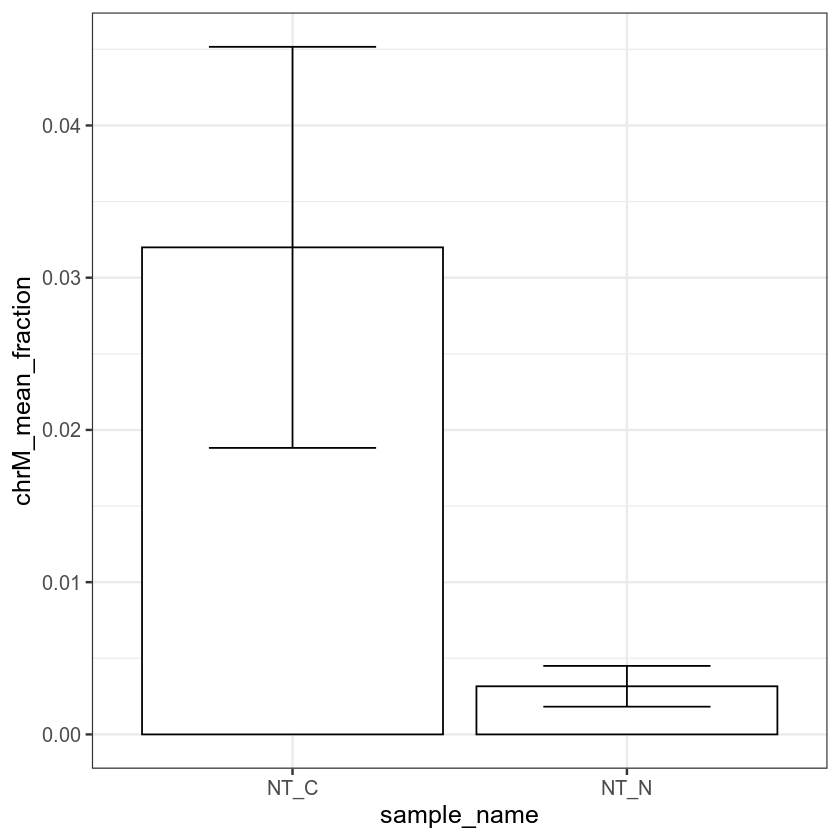

In [28]:
#### Count chrM reads
chrM_counts = colSums(data.frame(mcols(pA)[seqnames(pA)=="chrM",])[,sample_names])
total_counts = colSums(data.frame(mcols(pA))[,sample_names])
df = data.frame(chrM_counts, total_counts)
df$chrM_fraction = df$chrM_counts/df$total_counts
df = df[sort(rownames(df)),]
df$sample_name = rownames(df)

p = ggplot(df, aes(x = sample_name, y = chrM_fraction)) +
    geom_bar(stat = "identity") +
    scale_fill_hue(h.start = 180) 
  
png(file.path(result_dir, "chrM_reads_fraction.png"), 100*nrow(df), 500)
print(p)
dev.off()

# Calculate mean and sd of chrM fractions
if(length(batches) > 1){
 df$sample_name = sub(paste0("_(", paste(batches, collapse = "|"), ")"), "", df$sample_name)
  df = df %>%
    group_by(sample_name) %>%
    summarise(chrM_mean_fraction = mean(chrM_fraction), chrM_fraction_sd = sd(chrM_fraction)) 
  
  p = ggplot(df, aes(x=sample_name, y=chrM_mean_fraction)) +
    geom_col(fill="white", color = "black") +
    geom_errorbar(aes(x=sample_name, 
                      ymin=chrM_mean_fraction-chrM_fraction_sd, 
                      ymax=chrM_mean_fraction+chrM_fraction_sd), 
                  width = 0.5)
  
  png(file.path(result_dir, "mean_chrM_reads_fraction.png"), 100*nrow(df), 500)
  print(p)
  dev.off()
  p
}

In [29]:
#### Add 5'UTR, CDS, intron, and ncRNA features
pA.df = cbind(data.frame(chr = seqnames(pA), strand = strand(pA), pA_pos = start(pA)), data.frame(mcols(pA)))
pA.df$pAid = with(pA.df, paste0(chr, strand, pA_pos))
utr3 = pA.df %>%
  dplyr::filter(region == "3UTR") %>%
  left_join(CDS_features, by = "gene_symbol") %>%
  left_join(UTR5_features, by = "maxCDS_tx") %>%
  left_join(intron_features, by = "maxCDS_tx") 

other = pA.df %>%
  dplyr::filter(region != "3UTR") %>%
  left_join(ncRNA_features, by = "gene_symbol")
  
pA.df = bind_rows(utr3, other)

pA.df[pA.df$region == "ncRNA", ]$tx_size = pA.df[pA.df$region == "ncRNA", ]$ncRNA_size 

rm(txDb)
rm(CDS_features)
rm(intron_features)
rm(UTR5_features)
rm(ncRNA_features)

Warning message:
“Column `maxCDS_tx` joining character vector and factor, coercing into character vector”Warning message in `[<-.data.frame`(`*tmp*`, pA.df$region == "ncRNA", , value = structure(list(:
“provided 29 variables to replace 28 variables”Warning message in rm(txDb):
“object 'txDb' not found”

In [30]:
#### Calculate RPM, using total reads # between 0.5 and 0.95 quantile
for(sample_name in sample_names){
  all_counts = pA.df[pA.df$gene_symbol != "Unknown", sample_name] # only use genic reads
  lower_upper = quantile(all_counts, c(0.05, 0.95))
  trimmed_counts = all_counts[all_counts >= lower_upper[1] & all_counts <= lower_upper[2]]
  pA.df[,paste0(sample_name, "_rpm")] = 10^6*pA.df[,sample_name]/sum(trimmed_counts)
}

In [31]:
#### Calculate total reads number per gene, without counting pAs in UA 
num_per_gene = aggregate(pA.df[pA.df$region != "UA" & pA.df$region != "intergenic", sample_names], 
                         list(gene_symbol= pA.df[pA.df$region != "UA" & pA.df$region != "intergenic",]$gene_symbol), sum)
names(num_per_gene)[-1] = paste0(names(num_per_gene)[-1], "_gene")
pA.df = merge(pA.df, num_per_gene, all.x=T, sort = F)
rm(num_per_gene)

In [32]:
#### Calculate pA usage
for(sample_name in sample_names){
  pA.df[,paste0(sample_name, "_usage")] = 0
  pA.df[pA.df$region != "UA", paste0(sample_name, "_usage")] = 
    100*pA.df[pA.df$region != "UA", sample_name]/pA.df[pA.df$region != "UA", paste0(sample_name, "_gene")]
}

In [33]:
#### Calculate total 3'UTR reads per gene
num_in_3utr_per_gene = aggregate(pA.df[pA.df$region == "3UTR", sample_names], 
                                 list(gene_symbol= pA.df[pA.df$region == "3UTR",]$gene_symbol), sum)
names(num_in_3utr_per_gene)[-1] = paste0(names(num_in_3utr_per_gene)[-1], "_3utr")
pA.df = merge(pA.df, num_in_3utr_per_gene, all.x=T, sort = F)
rm(num_in_3utr_per_gene)

In [34]:
#### Calculate total 3'UTR rpms per gene
rpm_in_3utr_per_gene = aggregate(pA.df[pA.df$region == "3UTR", paste0(sample_names, "_rpm")], 
                                 list(gene_symbol= pA.df[pA.df$region == "3UTR",]$gene_symbol), sum)
names(rpm_in_3utr_per_gene)[-1] = paste0(names(rpm_in_3utr_per_gene)[-1], "_3utr")
pA.df = merge(pA.df, rpm_in_3utr_per_gene, all.x=T, sort = F)
rm(rpm_in_3utr_per_gene)
# Change column names
colnames(pA.df) = sub("(_\\d+[a-z]?)$", "\\1_count", colnames(pA.df))

In [35]:
#### Filter pAs
if(exists("filter_strength")){
  if(filter_strength < 0 | filter_strength > 1){
    stop("filter_strength must be between 0 and 1.")
  }
}else{
  filter_strength = 1/2 # between 0 and 1, bigger filter_strength means more stringent filtering
}
filter1 = rowSums(pA.df[,grepl("_usage$", names(pA.df))] >= lowest_usage, na.rm = T) >= length(sample_names)*filter_strength
filter2 = rowSums(pA.df[,grepl("_rpm$", names(pA.df))] >= lowest_rpm, na.rm = T) >= length(sample_names)*filter_strength
filter3 = rowSums(pA.df[,grepl("_count$", names(pA.df))] >= lowest_count, na.rm = T) >= length(sample_names)*filter_strength
# Keep pAs in other genic regions (outside of 3'UTRs)
filter4 = pA.df$region != "3UTR"
pA.df = pA.df[(filter1 & filter2 & filter3)|filter4,]
if(exists("filter_by_conservation") && filter_by_conservation){
  pA.df = subset(pA.df, !is.na(conserveLV) & conserveLV != "C")
}

In [36]:
#### Calculate exonic 3'UTR sequence/length
# Two columns (exonic_3UTR_seq, UTR_length) will be appended to df. The columns may contain NA.
# This step was done after the filtering for speed
pA.df = get_exonic_3UTR(df = pA.df, threeUTRs = threeUTRs, geno = GENOME)
tx_size = pA.df[, c("UTR5_size", "CDS_size", "UTR_length")]
tx_size[tx_size == -1] = 0
tx_size[is.na(tx_size)] = 0
pA.df$tx_size = rowSums(tx_size)
rm(tx_size)

In [37]:
#### Calculate pA_type
pA.df$pA_type = ifelse(pA.df$region %in% c("intron", "3UTR|intron", "3UTR|intron|CDS", "intron|5UTR", "intron|CDS", "intron|CDS|5UTR"), 
                       "I", 
                       ifelse(pA.df$region %in% c("5UTR", "CDS", "CDS|5UTR"), 
                              "E", 
                              ifelse(pA.df$region == "UA",
                                     "UA",
                                     ifelse(pA.df$region == "intergenic",
                                            "Intergenic",
                                            "SFML")))) # ncRNA may also have SFML types
pA.df$pA_type[table(pA.df$gene_symbol)[pA.df$gene_symbol] == 1 & pA.df$pA_type == "SFML"] = "S"
pA.df$signed_pA_pos = pA.df$pA_pos * ifelse(pA.df$strand == "+", 1, -1)
tmp = filter(pA.df, pA_type == "SFML") %>%
  group_by(gene_symbol) %>%
  mutate(percrank=percent_rank(signed_pA_pos))
tmp$pA_type = ifelse(tmp$percrank == 0, "F", 
                     ifelse(tmp$percrank == 1, "L", "M"))
pA.df = rbind(pA.df[pA.df$pA_type != "SFML",], as.data.frame(tmp[, -grep("percrank", names(tmp))]))
pA.df %<>% group_by(gene_symbol) %>%
  arrange(signed_pA_pos)
rm(tmp)
pA.df = as.data.frame(pA.df)

In [38]:
#### Set the "region" of intergenic pAs on mitochondria to "chrM"
pA.df[pA.df$region == "intergenic" & pA.df$chr == "chrM", ]$region = "chrM"
pA.df[pA.df$pA_type == "Intergenic" & pA.df$chr == "chrM", ]$pA_type = "chrM"

In [39]:
#### Calculate PAS using the 40 nt sequence upstream of pA
motifcounts = countAllMotif(pA.df, geno = GENOME, search_from = 0, search_len = 40, motif_width = 6)
motifcounts = motifcounts[, colnames(motifcounts) %in% c("AATAAA","ATTAAA", 
                            "AGTAAA", "TATAAA", "CATAAA", "GATAAA", "AATATA", "AATACA", "AATAGA", "AAAAAG",
                            "ACTAAA", "AAAAAA")]
PAScounts = cbind(motifcounts[, c("AATAAA","ATTAAA")], 
                  OtherPAS = rowSums(motifcounts[, c("AGTAAA", "TATAAA", "CATAAA", "GATAAA", 
                                                  "AATATA", "AATACA", "AATAGA", "AAAAAG",
                                                  "ACTAAA")]),
                  Arich = motifcounts[, "AAAAAA"])
PAScounts = as.data.frame(PAScounts)
pA.df$PAS = ifelse(PAScounts$AATAAA > 0, "AATAAA", 
                   ifelse(PAScounts$ATTAAA > 0, "ATTAAA",
                          ifelse(PAScounts$OtherPAS > 0, "OtherPAS",
                                 ifelse(PAScounts$Arich > 0, "Arich", "NoPAS"))))
rm(motifcounts)
rm(PAScounts)

In [40]:
#### Calculate genewise RPM
for(samplename in sample_names){
  all_counts = pA.df[, paste0(samplename, "_count")]
  lower_upper = quantile(all_counts, c(0.05, 0.95))
  trimmed_counts = all_counts[all_counts >= lower_upper[1] & all_counts <= lower_upper[2]]
  pA.df[, paste0("Gene_RPM_", samplename)] = 10^6 * pA.df[, paste0(samplename, "_gene")]/sum(trimmed_counts)
}

In [41]:
#### Calculate number of pAs per gene
Num_pA = as.data.frame(table(pA.df$gene_symbol[pA.df$gene_symbol != "Unknown"]))
names(Num_pA) = c("gene_symbol", "Num_pA")
pA.df = merge(pA.df, Num_pA, by = "gene_symbol", all.x = T, sort=F)
rm(Num_pA)

In [42]:
#### Calculate distance between pA site and TSS
pA.df$distance_to_tss = abs(pA.df$pA_pos - pA.df$tss_position)
pA.df$distance_to_tss = ifelse(pA.df$region == "UA", -1*pA.df$distance_to_tss, pA.df$distance_to_tss)

In [43]:
#### Add gene_symbol and gene_id using org.x.db
pA.df$gene_id = as.numeric(mapIds(org.db, keys = pA.df$gene_symbol, keytype =  "SYMBOL", column =  "ENTREZID"))
pA.df$description = mapIds(org.db, keys = pA.df$gene_symbol, keytype =  "SYMBOL", column =  "GENENAME")

'select()' returned 1:many mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


In [44]:
# #### Output RPM files
# x = pA.df[,c("chr", "strand", "tss_position", "pA_pos", "gene_symbol", "region", "cds_start", "cds_end", "UTR5_size", 
#              "CDS_size", "UTR5_GC", "CDS_GC", "max_intron_size", "min_intron_size", "total_intron_size", "num_intron", 
#              "UTR_length", "tx_size", "pA_type", "conserveLV", "PAS", "ncRNA_size", "ncRNA_GC", 
#              grep("count$|_rpm", names(pA.df), value=T), "description")]
# x[,grep("_rpm$", names(x))] = round(x[,grep("_rpm$", names(x))], 1)
# x[,grep("_usage$", names(x))] = round(x[,grep("_usage$", names(x))], 1)
# x[x==-1] = NA # unknown UTR length were -1
# x$gene_symbol[x$gene_symbol == "Unknown"] = NA
# names(x) = sub("(.+)_rpm", "RPM_\\1", names(x))
# names(x) = sub("(.+)_usage", "Isoform_abn_\\1", names(x))
# write.csv(x, file.path(result_dir, "RPM.csv"), row.names = F)
# rm(x)

# #### Plot correlations between samples
# if(length(sample_names) > 2){
#   pdf(file.path(result_dir, "clustering_samples.pdf"), width=20, height=10)
#   tmp = pA.df[,grep("_usage", colnames(pA.df))]
#   tmp = subset(tmp, rowSums(tmp[,grep("_usage", colnames(tmp))]) < length(grep("_usage", colnames(tmp)))*100)
#   names(tmp) = sub("_usage", "", names(tmp))
#   plot(hclust(dist(t(tmp))),main="Cluster by Relative Abundance")
#   
#   tmp = pA.df[, grep("_rpm", colnames(pA.df))]
#   for(colname in grep("_rpm$", colnames(pA.df), value = T)){
#     tmp[,paste0(colname, "_log")] = log2(pA.df[, colname]+1)
#   }
#   tmp = tmp[,grep("_rpm_log", colnames(tmp))]
#   names(tmp) = sub("_rpm_log", "", names(tmp))
#   tmp = subset(tmp, rowSums(tmp) > -100) # remove rows containing -Inf due to log(0) 
#   plot(hclust(dist(t(tmp))),main="Cluster by log2 RPM")
#   
#   dev.off()
#   rm(tmp)
# }